Poniższy projekt ma na celu przybliżenie architektury U-net powszechnie stosowanej do segmentacji obrazów oraz porównanie wydajności modelu uczonego od zera na relatywnie małym zbiorze danych treningowych z modelem wytrenowanym wcześniej na zbiorze większym i fine tune'owanym na małym zbiorze

In [1]:
import torch

#check for cuda availability
torch.cuda.is_available()



True

Tworzymy transformację którą potraktujemy nasze dane, żeby zwiększyć ich różnorodność

In [2]:
from torchvision import transforms as T
import torchvision.transforms.functional as TF
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
import random
from torch.utils.data import ConcatDataset


def default_transform_fn(img, mask):
    angle = random.uniform(-15.0, 15.0)  # Generate a single angle
    if random.random() < 0.5:
        img = TF.hflip(img)
        mask = TF.hflip(mask)
    if random.random() < 0.5:
        img = TF.vflip(img)
        mask = TF.vflip(mask)
    img = TF.resize(img,[256, 256], interpolation=T.InterpolationMode.BILINEAR)
    img = TF.rotate(img, angle)
    img = TF.to_tensor(img)
    img = TF.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


    mask = TF.resize(mask,[256, 256], interpolation=T.InterpolationMode.NEAREST)
    mask = TF.rotate(mask, angle)
    mask = TF.pil_to_tensor(mask)

    return img, mask


Do treningu będziemy używać danych PascalVOC dla segmentacji

In [3]:

train_dataset =VOCSegmentation(
    root='./data', year='2012', image_set='train',
    transforms=default_transform_fn,

)
train_dataset_2007 = VOCSegmentation(
    root='./data', year='2007', image_set='train',
    transforms=default_transform_fn, download=False,
)

combined_train_dataset = ConcatDataset([train_dataset,train_dataset_2007])

test_dataset = VOCSegmentation(
    root='./data', year='2012', image_set='val',
    transform=T.Compose([T.Resize((256, 256)), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),  # No augmentation for test data
    target_transform=T.Compose([T.Resize((256,256), interpolation=T.InterpolationMode.NEAREST), T.PILToTensor()])
)   


combined_train_loader = DataLoader(combined_train_dataset, batch_size=16, shuffle=True, num_workers=0)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0)


Przykładowe obrazki wraz z maskami dla zbioru testowego


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.5179958].


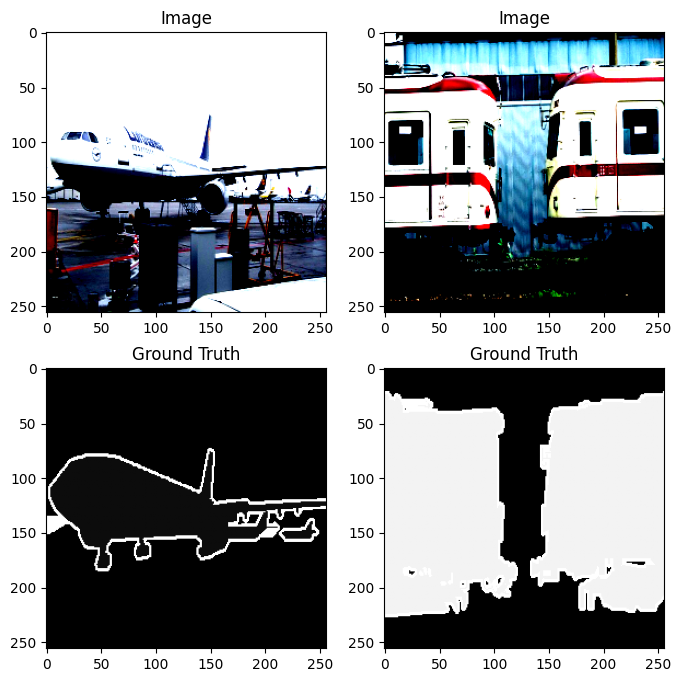

In [4]:
import matplotlib.pyplot as plt

image,mask = next(iter(test_loader))
images_np = image.cpu().permute(0, 2, 3, 1).numpy()
masks_np = mask.squeeze(1).cpu().numpy()


fig, ax = plt.subplots(2,2,figsize=(8, 8))
for i in range(2):
    ax[0, i].imshow(images_np[i])
    ax[0, i].set_title("Image")
    ax[1, i].imshow(masks_np[i], cmap="gray", vmin=0, vmax=20)
    ax[1, i].set_title("Ground Truth")
plt.show()

Poniżej definiujemy sieć konwolucyjną bazującą na architekturze U-net

<img src="u-net-architecture.png" alt="unet" width="600"/>

In [5]:
import torch.nn as nn
import torch.nn.functional as F



class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(  
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Batch normalization
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),  # Batch normalization
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)


class Encoder(nn.Module):
    def __init__(self, in_channels=3, base_size = 64):
        super(Encoder, self).__init__()
        self.down_sample1 = nn.Sequential(
            ConvBlock(in_channels, base_size),
            
        )
        self.down_sample2 = nn.Sequential(
            nn.Conv2d(base_size, base_size, kernel_size=3, stride=2, padding=1),  # Downsample
            ConvBlock(base_size, 2 * base_size),
            
        )
        self.down_sample3 = nn.Sequential(
            nn.Conv2d(2 * base_size, 2 * base_size, kernel_size=3, stride=2, padding=1),
            ConvBlock(2 * base_size, 4 * base_size),
            
        )
        self.down_sample4 = nn.Sequential(
            nn.Conv2d(4 * base_size, 4 * base_size, kernel_size=3, stride=2, padding=1),
            ConvBlock(4 * base_size, 8 * base_size)
        )
        self.output_channels = 8 * base_size

        self.output_channels = 8 * base_size  # Output channels after the last down-sampling layer
    def forward(self, x):
        s1 = self.down_sample1(x)
        s2 = self.down_sample2(s1)
        s3 = self.down_sample3(s2)
        s4 = self.down_sample4(s3)
        return [s1, s2, s3, s4] 
    


    

class Decoder(nn.Module):
    def __init__(self,  base_size):
        super(Decoder, self).__init__()
        self.base_size = base_size
        self.up1 = nn.ConvTranspose2d(base_size, base_size//2, kernel_size=2, stride=2)
        self.conv1 = ConvBlock(base_size, base_size//2)
        self.up2 = nn.ConvTranspose2d(base_size//2, base_size//4, kernel_size=2, stride=2)
        self.conv2 = ConvBlock(base_size//2, base_size//4)
        self.up3 = nn.ConvTranspose2d(base_size//4, base_size//8, kernel_size=2, stride=2)
        self.conv3 = ConvBlock(base_size//4, base_size//8)
        self.up4 = nn.ConvTranspose2d(base_size//8, base_size//16, kernel_size=2, stride=2)
        self.conv4 = ConvBlock(base_size//8, base_size//16)



    def forward(self, stages, b):
        s1,s2,s3,s4 = reversed(stages)
        b = self.up1(b)
        b = self.conv1(torch.cat([b, s1], dim=1))  # Skip connection
        b = self.up2(b)
        b = self.conv2(torch.cat([b, s2], dim=1))  # Skip connection
        b = self.up3(b)
        b = self.conv3(torch.cat([b, s3], dim=1))  # Skip connection
        b = self.up4(b)
        b = self.conv4(torch.cat([b, s4], dim=1))  # Skip connection
        return b

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=21, base_size = 64, backbone=None):

        super(UNet, self).__init__()
        if backbone is not None:
            self.encoder = backbone
        else:
            self.encoder = Encoder(in_channels, base_size)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(self.encoder.output_channels, self.encoder.output_channels, kernel_size=3, stride=2, padding=1),
            ConvBlock(self.encoder.output_channels, 2*self.encoder.output_channels),
            
        )
        self.bottleneck_dropout = nn.Dropout(0.1)

        self.decoder = Decoder(2*self.encoder.output_channels)

        # Final Output Layer
        self.final_batch_norm = nn.BatchNorm2d(base_size)
        self.final_conv = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(base_size, out_channels, kernel_size=1)
        )



    def forward(self, x):
        stages = self.encoder(x)
        # Bottleneck
        b = self.bottleneck(stages[-1])
        b = self.bottleneck_dropout(b)
        # Decoder with Skip Connections
        d1 = self.decoder(stages, b)

        # Final output layer
        d1 = self.final_batch_norm(d1)
        return {'out' : self.final_conv(d1)}

Definiujemy metrykę Intersection over Union, która będzie służyć jako miara testowa wydajności naszego modelu. Jest nieróżniczkowalna więc nie można jej użyć do treningu, natomiast istnieje funkcja dice loss która mierzy dokładność w podobny sposób i jest różniczkowalna, lecz w celu uproszczenia posłużymy się zwykłą entropią krzyżową

In [6]:
from torchmetrics import JaccardIndex


class IoULoss(nn.Module):
    def __init__(self, num_classes=21, ignore_index=255):
        super(IoULoss, self).__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.iou_metric = JaccardIndex(task="multiclass", num_classes=num_classes,average='macro')

    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)
        pred = torch.argmax(pred, dim=1)

        # Create mask where target != ignore_index
        mask = target != self.ignore_index

        # Apply mask
        pred = pred[mask]
        target = target[mask]

        if pred.numel() == 0:
            return torch.tensor(0.0, device=pred.device)  # prevent division by zero

        return self.iou_metric(pred, target)

Klasa Trainer enkapsuluje funkcjonalności związane z pętlą treningową dla modelu, wyposażona w SummaryWriter z tensorboard w celu umożliwienia śledzenia krzywych uczenia w czasie rzeczywistym

In [7]:
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
class Trainer:
    def __init__(self, model, train_loader, test_loader, device, model_name="unet",writer = None, use_scheduler=True):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.weights = torch.tensor([0.5] + 20*[1.0]).to(device) 
        self.weights = self.weights / self.weights.sum()  # Normalize weights 
        self.criterion = nn.CrossEntropyLoss(weight=self.weights.to(device), ignore_index=255).to(device)
        self.accuracy_metric = IoULoss(num_classes=21).to(device)
        self.history = []
        self.model_name = model_name
        if writer is None:
            self.writer = SummaryWriter(log_dir=f"runs/{model_name}")
        else:
            self.writer = writer
        self.use_scheduler = use_scheduler

    def train(self, epochs):
        if self.use_scheduler:
            self.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=epochs, eta_min=0.00001)
        else:
            self.lr_scheduler = None
        i = 0
        curr_best_accuracy = 0.0
        ct = 0
        patience = 10
        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0
            running_accuracy = 0.0
            for images, masks in self.train_loader:
                images, masks = images.to(self.device), masks.squeeze(1).to(self.device, dtype=torch.long)

                self.optimizer.zero_grad()
                outputs = self.model(images)['out']

                loss = self.criterion(outputs, masks)
                loss.backward()
                self.optimizer.step()


                accuracy = self.accuracy_metric(outputs, masks)
                running_loss += loss.item()
                running_accuracy += accuracy.item()
                #log loss and accuracy
                accuracy = self.accuracy_metric(outputs, masks)
                self.history.append({"epoch": i+1  * self.train_loader.batch_size ,"loss": loss.item(), "accuracy": accuracy.item()})
                i += 1
            self.writer.add_scalar('Loss/train', running_loss/len(self.train_loader), epoch)
            self.writer.add_scalar('Accuracy/train', running_accuracy/len(self.train_loader), epoch)
            self.writer.flush()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(self.train_loader):.4f}\n Accuracy: {running_accuracy/len(self.train_loader):.4f}")
            if (epoch) % 5 == 0:
                self.model.eval()
                accuracy,loss = self.evaluate()
                self.writer.add_scalar('Loss/test', loss, epoch)
                self.writer.add_scalar('Accuracy/test', accuracy, epoch)
                if accuracy > curr_best_accuracy:
                    curr_best_accuracy = accuracy
                    torch.save(self.model.state_dict(), f"models/best_model_{self.model_name}.pth")
                    print(f"Best model saved at epoch {epoch+1} with accuracy {curr_best_accuracy:.4f}")
                else:
                    ct += 1
                    if ct >= patience:
                        print(f"Early stopping at epoch {epoch+1} with accuracy {curr_best_accuracy:.4f}")
                        self.model.load_state_dict(torch.load(f"models/best_model_{self.model_name}.pth"))
                        break
        self.writer.close()
        torch.save(self.model.state_dict(), f"models/best_model_{self.model_name}.pth")
        print("Training complete. Model saved.")
        return pd.DataFrame(self.history)

    def evaluate(self):
        self.model.eval()
        total_iou = 0.0
        total_loss = 0.0
        with torch.no_grad():
            for images, masks in self.test_loader:
                images, masks = images.to(self.device), masks.squeeze(1).to(self.device, dtype=torch.long)
                outputs = self.model(images)['out']
                iou = self.accuracy_metric(outputs, masks)
                total_iou += iou.item()
                loss = self.criterion(outputs, masks)
                total_loss += loss.item()
        print(f"Mean IoU: {total_iou / len(self.test_loader):.4f}")
        return total_iou / len(self.test_loader), total_loss / len(self.test_loader)

Spróbujemy teraz wytrenować nasz model, nie mamy wysokich oczekiwań gdyż zbiór treningowy jest relatywnie mały.

In [8]:
from datetime import datetime
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model = UNet(in_channels=3, out_channels=21, base_size=32).to(device)
writer = SummaryWriter(log_dir=f'runs/unet_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
trainer = Trainer(
    model=my_model,
    train_loader=combined_train_loader,
    test_loader=test_loader,
    device=device,
    model_name="unet",
    writer=writer
)
my_history = trainer.train(epochs=200)

Epoch [1/200], Loss: 2.2850
 Accuracy: 0.0430
Mean IoU: 0.0803
Best model saved at epoch 1 with accuracy 0.0803
Epoch [2/200], Loss: 1.7396
 Accuracy: 0.0554
Epoch [3/200], Loss: 1.6643
 Accuracy: 0.0566
Epoch [4/200], Loss: 1.6460
 Accuracy: 0.0586
Epoch [5/200], Loss: 1.6268
 Accuracy: 0.0598
Epoch [6/200], Loss: 1.6184
 Accuracy: 0.0597
Mean IoU: 0.0807
Best model saved at epoch 6 with accuracy 0.0807
Epoch [7/200], Loss: 1.5934
 Accuracy: 0.0606
Epoch [8/200], Loss: 1.5850
 Accuracy: 0.0604
Epoch [9/200], Loss: 1.5677
 Accuracy: 0.0606
Epoch [10/200], Loss: 1.5555
 Accuracy: 0.0632
Epoch [11/200], Loss: 1.5473
 Accuracy: 0.0645
Mean IoU: 0.0781
Epoch [12/200], Loss: 1.5223
 Accuracy: 0.0672
Epoch [13/200], Loss: 1.5138
 Accuracy: 0.0682
Epoch [14/200], Loss: 1.5001
 Accuracy: 0.0695
Epoch [15/200], Loss: 1.4992
 Accuracy: 0.0716
Epoch [16/200], Loss: 1.4911
 Accuracy: 0.0685
Mean IoU: 0.0801
Epoch [17/200], Loss: 1.4739
 Accuracy: 0.0713
Epoch [18/200], Loss: 1.4631
 Accuracy: 0.07

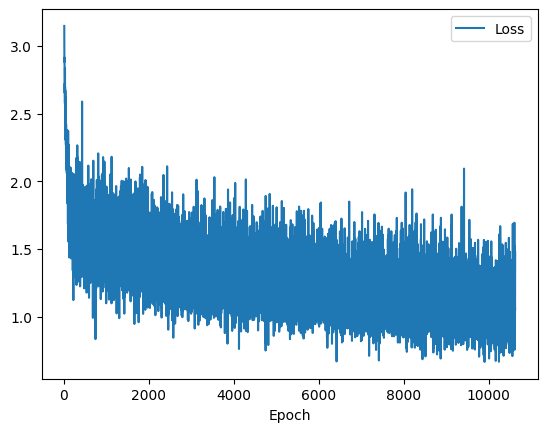

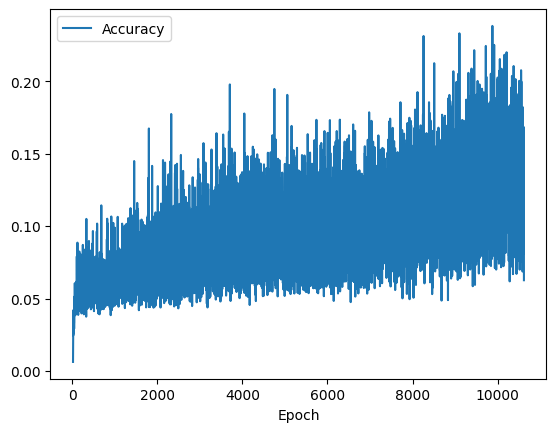

In [9]:


plt.plot(my_history["epoch"], my_history["loss"])
plt.xlabel("Epoch")
plt.legend(["Loss"])
plt.show()
plt.plot(my_history["epoch"], my_history["accuracy"])
plt.xlabel("Epoch")
plt.legend(["Accuracy"])
plt.show()

In [10]:
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches

def plot_images_and_predictions(model, data_loader,skip_ground_truth=False):
    
    VOC_CLASSES = [
        "background","aeroplane", "bicycle", "bird", "boat", "bottle",
        "bus", "car", "cat", "chair", "cow",
        "diningtable", "dog", "horse", "motorbike", "person",
        "pottedplant", "sheep", "sofa", "train", "tvmonitor"
    ]

    model.eval()
    with (torch.no_grad()):

        images, masks = next(iter(data_loader))
        images, masks = images.to(device), masks.to(device, dtype=torch.long)
        outputs = model(images)['out']
        predicted_masks = torch.argmax(outputs, dim=1)

        # Convert to numpy for visualization
        images_np = images.cpu().permute(0, 2, 3, 1).numpy()
        masks_np = masks.squeeze(1).cpu().numpy()
        preds_np = predicted_masks.cpu().numpy()

        # Define a color map
        cmap = plt.get_cmap('tab20', 21)  # 21 classes

        # Prepare legend handles
        handles = [mpatches.Patch(color=cmap(i), label=f"{i}: {VOC_CLASSES[i]}") for i in range(len(VOC_CLASSES))]

        # Plot sample image, ground truth mask, and predicted mask
        if not skip_ground_truth:
            fig, axes = plt.subplots(3, 4, figsize=(12, 9))
            for i in range(4):  # Show 4 samples
                axes[0, i].imshow(images_np[i+4])
                axes[0, i].set_title("Image")
                axes[1, i].imshow(masks_np[i+4], cmap="tab20", vmin=0, vmax=20,interpolation="nearest")
                axes[1, i].set_title("Ground Truth")
                axes[2, i].imshow(preds_np[i+4], cmap="tab20", vmin=0, vmax=20,interpolation="nearest")
                axes[2, i].set_title("Predicted Mask")
            
        else:
            fig, axes = plt.subplots(2, 4, figsize=(12, 6))
            for i in range(4):
                axes[0, i].imshow(images_np[i+4])
                axes[0, i].set_title("Image")
                axes[1, i].imshow(preds_np[i+4], cmap="tab20", vmin=0, vmax=20,interpolation="nearest")
                axes[1, i].set_title("Predicted Mask")
        fig.legend(handles=handles, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.1659663].


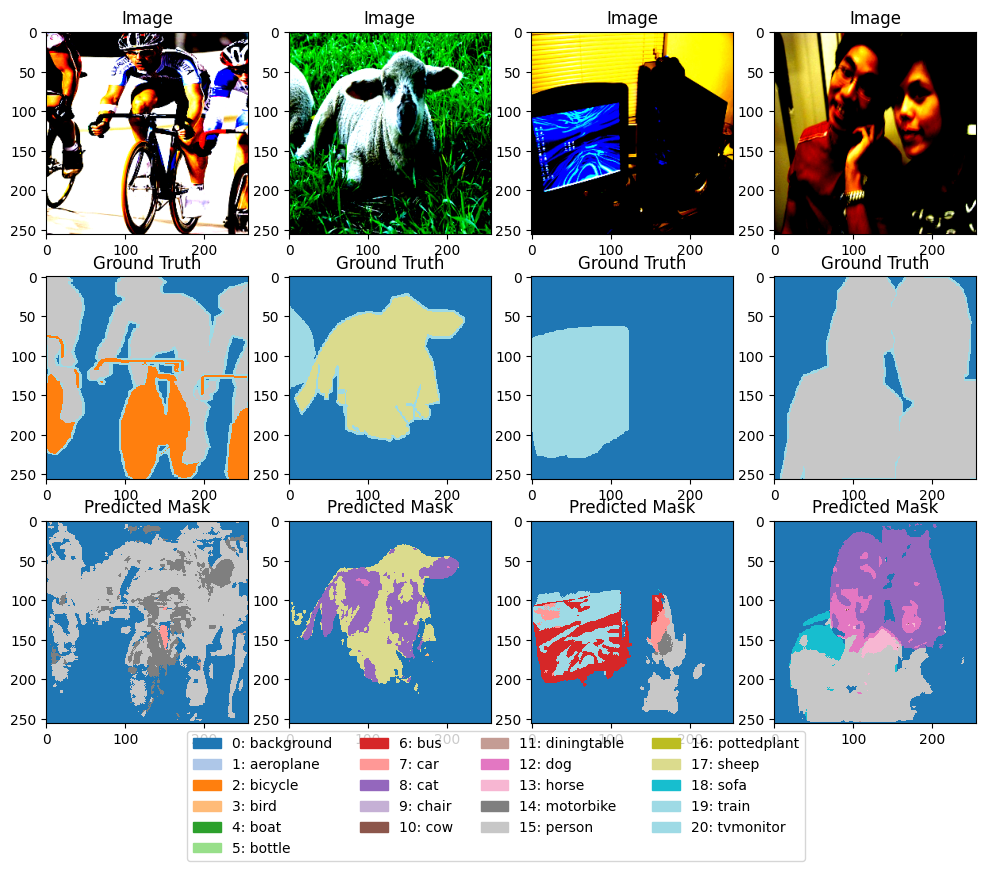

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.2556726].


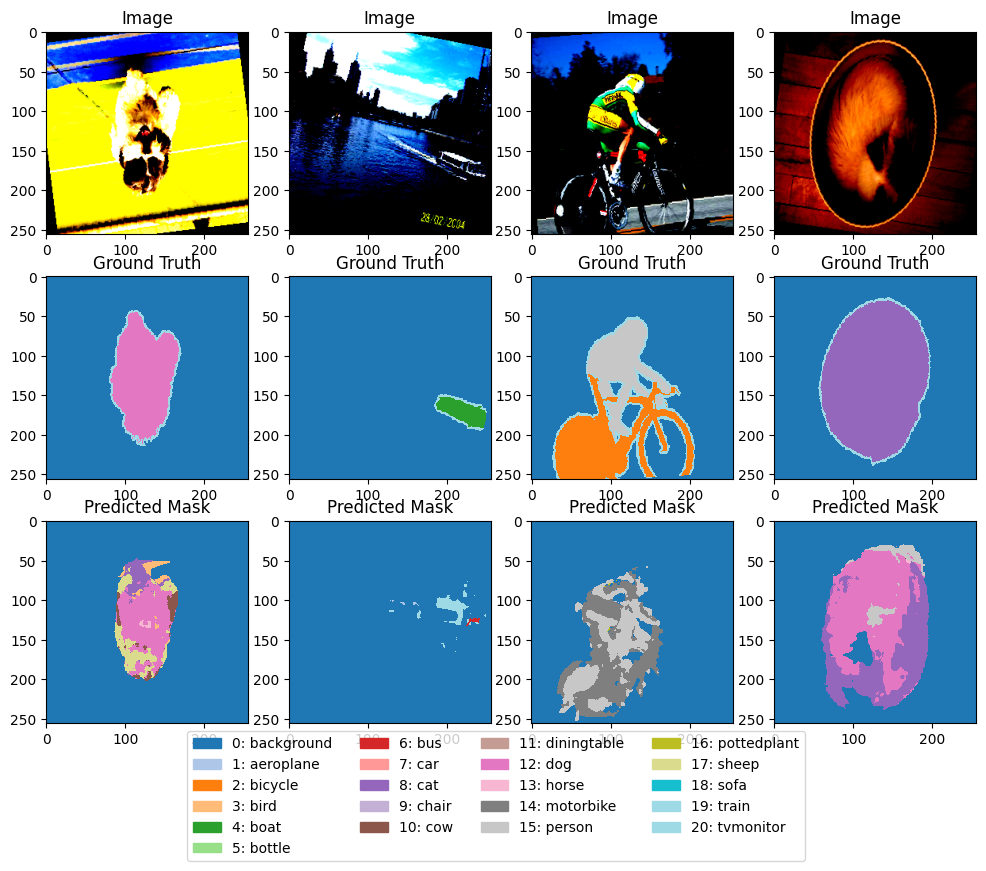

In [11]:
plot_images_and_predictions(my_model, test_loader)
plot_images_and_predictions(my_model, combined_train_loader)

Teraz spróbujemy coś innego, wytrenujemy klasyfikator bazujący na enkoderze U-Net, na nieco większym zbiorze pascal VOC do klasywikacji i tak wytrenowany "backbone" wstawimy do naszego U-neta i spróbujemy nauczyć jeszcze raz 

In [12]:
from torch.utils.data import Dataset
import os
from torchvision.datasets import VOCDetection

# 1) List the 20 VOC class names in the exact order VOC uses (indices 0..19)
VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]
CLASS_TO_IDX = {name: i for i, name in enumerate(VOC_CLASSES)}

class VOCWrapper(Dataset):
    def __init__(self, raw_dataset,  image_transform,label_cache_path='./data/voc_labels.pt'):
        self.raw_dataset = raw_dataset
        self.image_transform = image_transform
        self.labels = []
        if not os.path.exists(label_cache_path):
            for _, target in self.raw_dataset:
                objs = target["annotation"].get("object", [])
                if isinstance(objs, dict):
                    objs = [objs]
                label_vec = torch.zeros(len(VOC_CLASSES), dtype=torch.float32)
                for obj in objs:
                    cls_name = obj["name"]
                    if cls_name in CLASS_TO_IDX:
                        label_vec[CLASS_TO_IDX[cls_name]] = 1.0
                self.labels.append(label_vec)
            torch.save(self.labels, './data/voc_labels.pt')
        else:
            self.labels = torch.load('./data/voc_labels.pt')

    def __len__(self):
        return len(self.raw_dataset)

    def __getitem__(self, idx):
        img, _ = self.raw_dataset[idx]
        return self.image_transform(img,self.labels[idx])
    


# 2) Define transforms that take (PIL img, target_dict) → (Tensor img, Tensor multi_hot_label)
def detection_transform(img, target):
    if random.random() < 0.5:
        img = TF.hflip(img)
    if random.random() < 0.5:
        img = TF.vflip(img)
    

    img = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]),
    ])(img)
    

    return img, target

# 3) Load VOC2007 train+val using transforms=detection_transform
voc07_trainval = VOCDetection(
    root="./data",       # folder containing VOC2007/
    year="2007",
    image_set="trainval",
    download = False,

)

# 4) (Optional) Load VOC2012 train+val and concatenate for a bigger train set
voc12_trainval = VOCDetection(
    root="./data",
    year="2012",
    image_set="trainval",
    download=False,
)

combined_train = ConcatDataset([voc07_trainval,voc12_trainval])

# pascal voc classes are not mutually exclusive, so we need to create a multi-hot label vector

labeled_train = VOCWrapper(combined_train,  detection_transform)
labeled_val = VOCWrapper(voc07_trainval, detection_transform)
classifier_train_loader = DataLoader(
    labeled_train,
    batch_size=8,
    shuffle=True,
    num_workers=0,

)


classifier_val_loader = DataLoader(
    labeled_val,
    batch_size=8,
    shuffle=False,
    num_workers=0,
)



In [13]:
print(f"Number of training samples: {len(labeled_train)}")

Number of training samples: 16551


Teraz musimy stworzyć nasz klasyfikator oraz klasę do trenowania go

In [14]:
class Classifier(nn.Module):
    def __init__(self, in_channels=3, out_channels=20, base_size = 32):
        super(Classifier, self).__init__()
        self.encoder = Encoder(in_channels, base_size=base_size)
        self.classifier_conv = nn.Conv2d(self.encoder.output_channels, out_channels, kernel_size=1)

    def forward(self, x):
        enc_output = self.encoder(x)  # Get all encoder outputs
        # Use the last encoder output for classification
        out = self.classifier_conv(enc_output[-1])
        pooled = F.adaptive_avg_pool2d(out, (1, 1))  
        logits = pooled.view(pooled.size(0), -1)  # → (B, num_classes)
        return {'out': logits }

In [15]:
class ClassifierTrainer:
    def __init__(self, model, train_loader, val_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001)


    def train(self, epochs=10):
        self.model.train()
        patience = 5
        ct = 0
        best_accuracy = 0.0
        for epoch in range(epochs):
            avg_loss = 0.0
            
            for images, labels in self.train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)['out']
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                avg_loss += loss.item()
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss/len(self.train_loader):.4f}')
            
            if epoch % 5 == 0:
                val_loss,accuracy = self.evaluate()
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    torch.save(self.model.state_dict(), f'models/best_classifier_model.pth')
                    print(f'Best model saved at epoch {epoch+1} with accuracy {best_accuracy:.4f}')
                    ct = 0
                else:
                    ct += 1
                    if ct >= patience:
                        print(f'Early stopping at epoch {epoch+1} with best accuracy {best_accuracy:.4f}')
                        self.model.load_state_dict(torch.load(f'models/best_classifier_model.pth')) 
                        break
            


    def evaluate(self):
        self.model.eval()
        total_loss = 0.0
        total_samples = 0
        total_correct = 0
        total_labels = 0
        with torch.no_grad():
            for images, labels in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)['out']
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

                preds = (torch.sigmoid(outputs) > 0.5).float()

                total_correct += (preds == labels).sum().item()
                total_labels += labels.numel()

        accuracy = total_correct / total_labels if total_labels > 0 else 0
        print(f'Validation Loss: {total_loss / len(self.val_loader):.4f}, Accuracy: {accuracy:.4f}')
        return total_loss / len(self.val_loader), accuracy

In [16]:
classifier_model = Classifier(in_channels=3, out_channels=20, base_size=32).to(device)
classifier_trainer = ClassifierTrainer(
    model=classifier_model,
    train_loader=classifier_train_loader,
    val_loader=classifier_val_loader,
    device=device
)
classifier_trainer.train(epochs=11)

Epoch [1/11], Loss: 0.2488
Validation Loss: 0.2168, Accuracy: 0.9240
Best model saved at epoch 1 with accuracy 0.9240
Epoch [2/11], Loss: 0.2164
Epoch [3/11], Loss: 0.2045
Epoch [4/11], Loss: 0.1985
Epoch [5/11], Loss: 0.1931
Epoch [6/11], Loss: 0.1885
Validation Loss: 0.1835, Accuracy: 0.9323
Best model saved at epoch 6 with accuracy 0.9323
Epoch [7/11], Loss: 0.1845
Epoch [8/11], Loss: 0.1807
Epoch [9/11], Loss: 0.1777
Epoch [10/11], Loss: 0.1752
Epoch [11/11], Loss: 0.1727
Validation Loss: 0.1741, Accuracy: 0.9348
Best model saved at epoch 11 with accuracy 0.9348


In [17]:
classifier_model.load_state_dict(torch.load('models/best_classifier_model.pth'))
model_pretrained_backbone = UNet(in_channels=3, out_channels=21, base_size=32, backbone=classifier_model.encoder).to(device)
writer = SummaryWriter(log_dir=f'runs/unet_pretrained_backbone_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
trainer_pretrained_backbone = Trainer(
    model=model_pretrained_backbone,
    train_loader=combined_train_loader,
    test_loader=test_loader,
    device=device,
    model_name="unet_pretrained_backbone",
    writer=writer
)
history_pretrained = trainer_pretrained_backbone.train(epochs=200)

Epoch [1/200], Loss: 2.2599
 Accuracy: 0.0466
Mean IoU: 0.0704
Best model saved at epoch 1 with accuracy 0.0704
Epoch [2/200], Loss: 1.6780
 Accuracy: 0.0598
Epoch [3/200], Loss: 1.5999
 Accuracy: 0.0639
Epoch [4/200], Loss: 1.5446
 Accuracy: 0.0690
Epoch [5/200], Loss: 1.5297
 Accuracy: 0.0714
Epoch [6/200], Loss: 1.4892
 Accuracy: 0.0730
Mean IoU: 0.0824
Best model saved at epoch 6 with accuracy 0.0824
Epoch [7/200], Loss: 1.4788
 Accuracy: 0.0777
Epoch [8/200], Loss: 1.4538
 Accuracy: 0.0797
Epoch [9/200], Loss: 1.4360
 Accuracy: 0.0829
Epoch [10/200], Loss: 1.4358
 Accuracy: 0.0807
Epoch [11/200], Loss: 1.4091
 Accuracy: 0.0828
Mean IoU: 0.0902
Best model saved at epoch 11 with accuracy 0.0902
Epoch [12/200], Loss: 1.4087
 Accuracy: 0.0847
Epoch [13/200], Loss: 1.3926
 Accuracy: 0.0865
Epoch [14/200], Loss: 1.3824
 Accuracy: 0.0886
Epoch [15/200], Loss: 1.3694
 Accuracy: 0.0880
Epoch [16/200], Loss: 1.3583
 Accuracy: 0.0905
Mean IoU: 0.0949
Best model saved at epoch 16 with accurac

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.1659663].


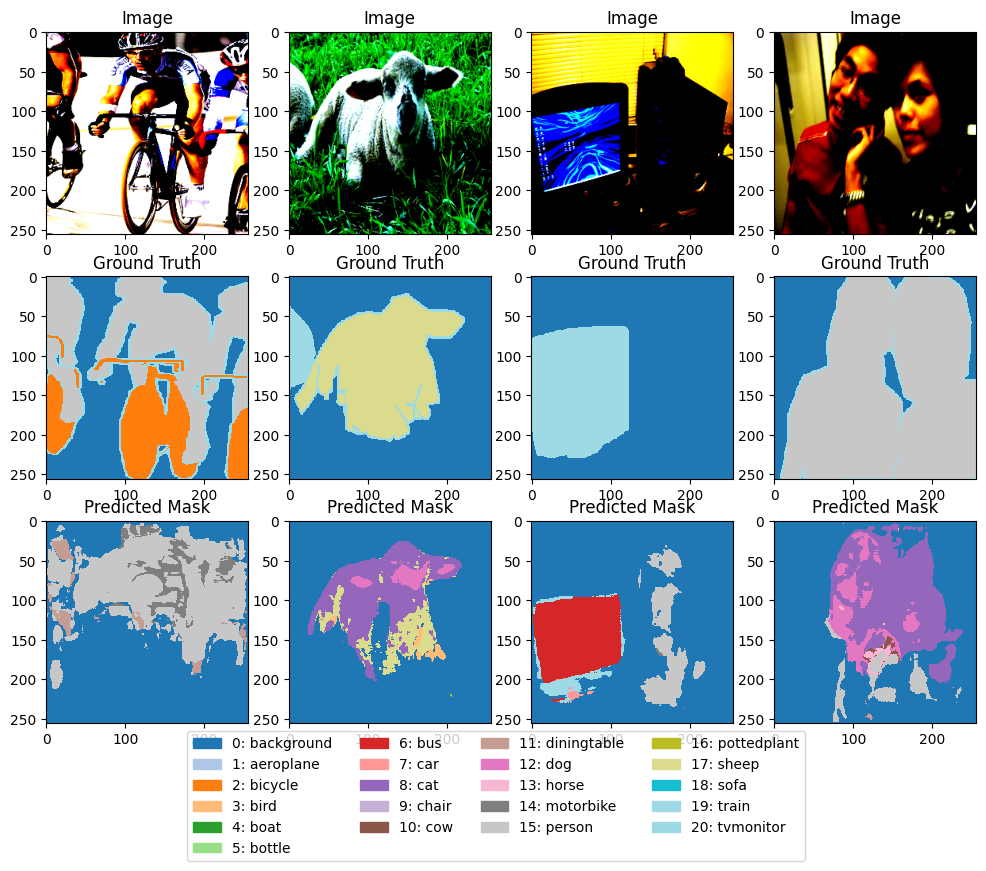

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.343704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8905448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3088455].


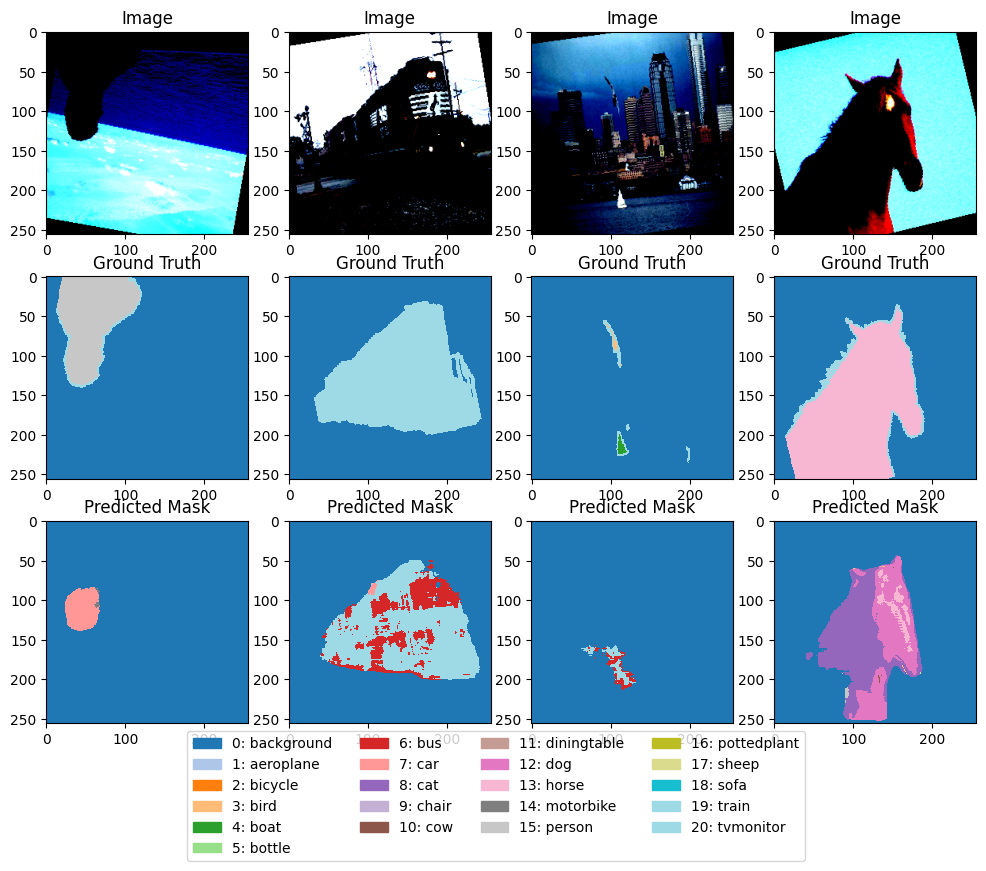

In [20]:
plot_images_and_predictions(model_pretrained_backbone, test_loader)
plot_images_and_predictions(model_pretrained_backbone, train_loader)

In [21]:
from torchvision.models.segmentation import deeplabv3_resnet50




# Load a pre-trained DeepLabV3 model
deeplab_model = deeplabv3_resnet50(pretrained=True)

deeplab_model.classifier[4] = nn.Conv2d(256, 21, kernel_size=1)

deeplab_model = deeplab_model.to(device)
#freeze the backbone
for param in deeplab_model.backbone.parameters():
    param.requires_grad = False
writer = SummaryWriter(log_dir=f'runs/deeplab_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

trainer_deeplab = Trainer(
    model=deeplab_model,
    train_loader=train_loader,
    test_loader=test_loader,
    device=device,
    model_name="deeplabv3",
    writer=writer,
    use_scheduler=False
)
deeplab_history = trainer_deeplab.train(epochs=20)

d:\Anaconda\envs\projekt\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\projekt\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 1.1628
 Accuracy: 0.2091
Mean IoU: 0.4259
Best model saved at epoch 1 with accuracy 0.4259
Epoch [2/20], Loss: 0.6880
 Accuracy: 0.3142
Epoch [3/20], Loss: 0.5864
 Accuracy: 0.3400
Epoch [4/20], Loss: 0.5851
 Accuracy: 0.3394
Epoch [5/20], Loss: 0.5408
 Accuracy: 0.3592
Epoch [6/20], Loss: 0.5031
 Accuracy: 0.3623
Mean IoU: 0.4925
Best model saved at epoch 6 with accuracy 0.4925
Epoch [7/20], Loss: 0.4818
 Accuracy: 0.3807
Epoch [8/20], Loss: 0.4466
 Accuracy: 0.3969
Epoch [9/20], Loss: 0.4409
 Accuracy: 0.3869
Epoch [10/20], Loss: 0.4208
 Accuracy: 0.4118
Epoch [11/20], Loss: 0.4199
 Accuracy: 0.3927
Mean IoU: 0.4982
Best model saved at epoch 11 with accuracy 0.4982
Epoch [12/20], Loss: 0.4004
 Accuracy: 0.4184
Epoch [13/20], Loss: 0.3919
 Accuracy: 0.4107
Epoch [14/20], Loss: 0.3732
 Accuracy: 0.4257
Epoch [15/20], Loss: 0.3523
 Accuracy: 0.4354
Epoch [16/20], Loss: 0.3567
 Accuracy: 0.4309
Mean IoU: 0.4913
Epoch [17/20], Loss: 0.3473
 Accuracy: 0.4324
Epoch [18/2

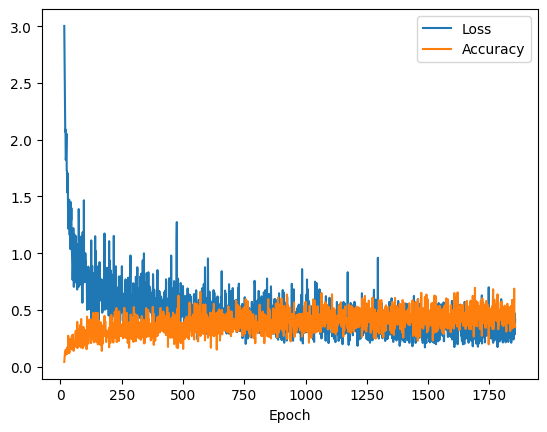

In [22]:
plt.plot(deeplab_history["epoch"], deeplab_history["loss"])
plt.xlabel("Epoch")
plt.plot(deeplab_history["epoch"], deeplab_history["accuracy"])
plt.legend(["Loss", "Accuracy"])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.1659663].


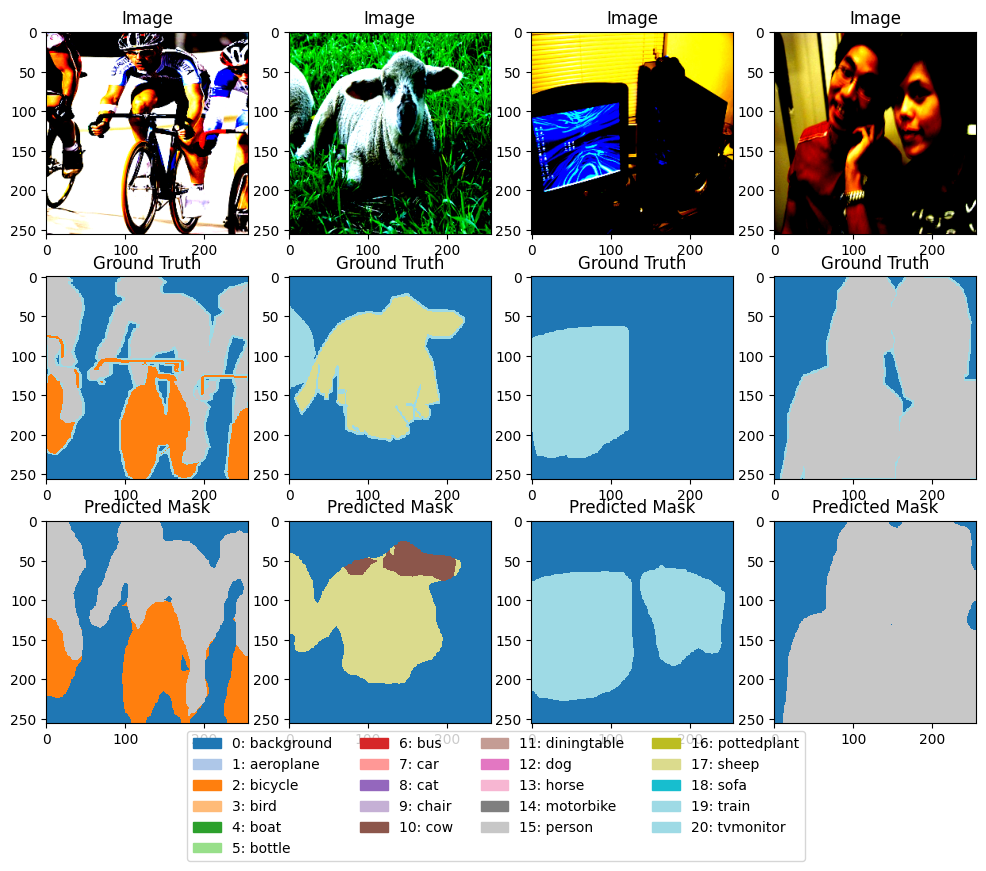

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6932774].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].


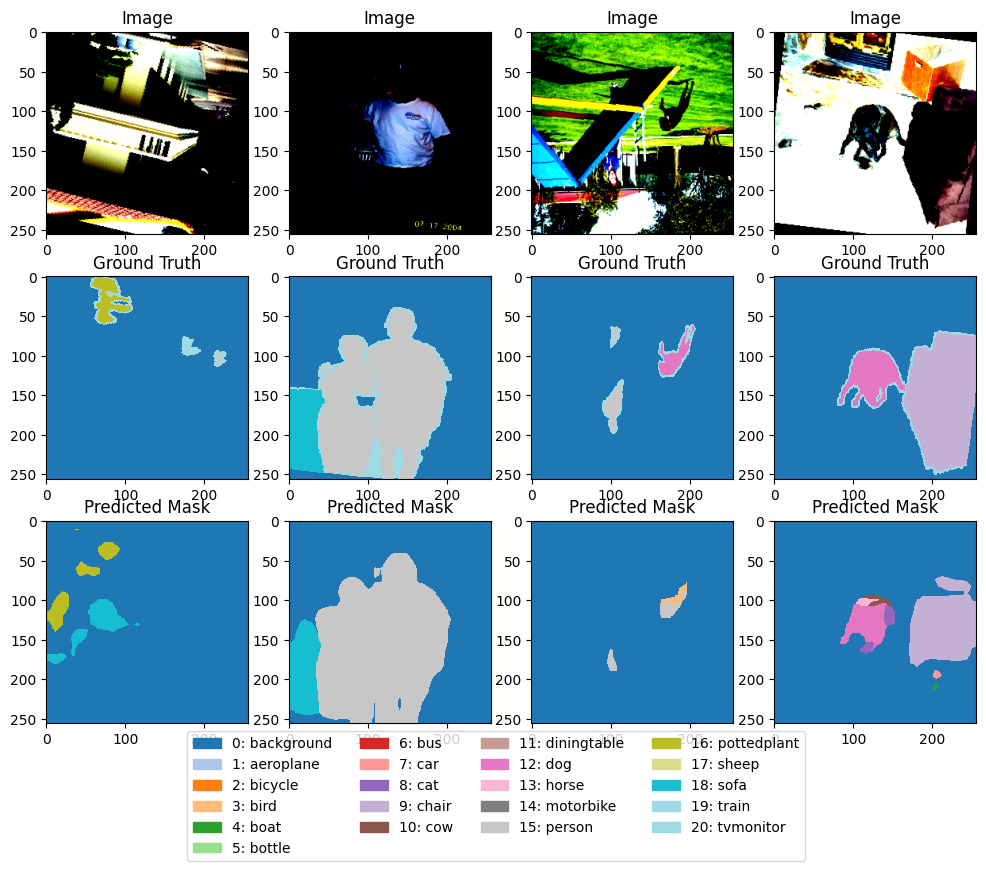

In [23]:
plot_images_and_predictions(deeplab_model, test_loader)
plot_images_and_predictions(deeplab_model, train_loader)